In [1]:
ours2orig = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 254, 41, 42, 43, 44, 45,
46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 85,
86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103,
104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 136, 138, 132,
133, 134, 135, 220, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 185, 186,
187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201,
202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216,
217, 218, 219, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232,
233, 137, 234, 235, 236, 237, 238, 239, 240, 241, 250, 251, 255, 256, 257,
258, 259, 260, 261, 262, 263, 242, 243, 244, 245, 0, 1, 2, 3, 4, 5, 6, 7, 8,
9, 10, 11, 83, 84, 131, 139, 140, 141, 181, 182, 183, 184, 246, 247, 248,
249, 252, 253]

def vec2mat(v):
    a,b = np.triu_indices(264,1)
    m = np.zeros((264,264))
    m[a,b] = v
    return m+m.T

def remap(fc, roimap=ours2orig):
    fc = fc[roimap,:]
    fc = fc[:,roimap]
    return fc

print('Complete')

Complete


In [2]:
# Load FC

import pickle
import numpy as np

pncdir = '/home/anton/Documents/Tulane/Research/ImageNomer/data/anton/cohorts/PNC/'
demo = pickle.load(open(f'{pncdir}/demographics.pkl', 'rb'))

rest = []
nback = []
emoid = []
race = []
sex = []
age = []
wrat = []
subids = []

a,b = np.triu_indices(264,1)

for sub in demo['age_at_cnb']:
    try:
        ra = demo['Race'][sub]
        ag = demo['age_at_cnb'][sub]
        se = demo['Sex'][sub]
        if ra not in ['AA', 'EA']:
            continue
        ra = ra == 'AA'
        se = se == 'M'
        r = np.load(f'{pncdir}/fc/{sub}_task-rest_fc.npy')
        n = np.load(f'{pncdir}/fc/{sub}_task-nback_fc.npy')
        e = np.load(f'{pncdir}/fc/{sub}_task-emoid_fc.npy')
        race.append(ra)
        sex.append(se)
        age.append(ag)
        rest.append(remap(vec2mat(r))[a,b])
        nback.append(remap(vec2mat(n))[a,b])
        emoid.append(remap(vec2mat(e))[a,b])
        subids.append(sub)
    except:
        pass

rest = np.stack(rest)
nback = np.stack(nback)
emoid = np.stack(emoid)
race = np.array(race).astype('int')
sex = np.array(sex).astype('int')
age = np.array(age)

age = (age - np.mean(age)) / np.std(age)

print([a.shape for a in [rest, nback, emoid, race, sex, age]])

[(1193, 34716), (1193, 34716), (1193, 34716), (1193,), (1193,), (1193,)]


In [3]:
from sklearn.linear_model import Ridge, LogisticRegression
import torch

age_reg = Ridge(alpha=100).fit(np.concatenate([rest, nback, emoid], axis=0), np.concatenate([age, age, age]))
age_w = torch.from_numpy(age_reg.coef_).float().cuda()
age_i = age_reg.intercept_

print(age_i)

0.34456667804954844


In [4]:
import pickle

mygen3 = pickle.load(open('/home/anton/Documents/Tulane/Research/ImageNomer/data/PNC/mygen3.pkl', 'rb'))

print('Done')

Done


In [5]:
# age_w = torch.from_numpy(mygen3['age_w']).float().cuda()
# age_i = mygen3['age_i']
sex_w = torch.from_numpy(mygen3['sex_w']).float().cuda()
sex_i = mygen3['sex_i']
race_w = torch.from_numpy(mygen3['race_w']).float().cuda()
race_i = mygen3['race_i']
rest_w = torch.from_numpy(mygen3['rest_w']).float().cuda()
rest_i = mygen3['rest_i']
nback_w = torch.from_numpy(mygen3['nback_w']).float().cuda()
nback_i = mygen3['nback_i']
emoid_w = torch.from_numpy(mygen3['emoid_w']).float().cuda()
emoid_i = mygen3['emoid_i']

print(age_w.shape, age_i, sex_w.shape, sex_i, race_w.shape, race_i)

torch.Size([34716]) 0.34456667804954844 torch.Size([34716]) -5.628305026005052 torch.Size([34716]) 13.770769923836573


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import random

class VAE(nn.Module):
    def __init__(self, fcd, ld):
        super(VAE, self).__init__()
        self.fcd = fcd
        self.ld = ld
        self.enc1 = nn.Linear(fcd, 1000).float().cuda()
        self.enc2 = nn.Linear(1000, ld).float().cuda()
        self.dec1 = nn.Linear(ld+6, 1000).float().cuda()
        self.dec2 = nn.Linear(1000, fcd).float().cuda()

    def enc(self, x):
        x = F.relu(self.enc1(x))
        z = self.enc2(x)
        return z

    def gen(self, n):
        return torch.randn(n, self.ld).float().cuda()/(10**0.5)
    
    def dec(self, z, age, sex, race, rest, nback, emoid):
        z = torch.cat([z, age.unsqueeze(1), sex.unsqueeze(1), race.unsqueeze(1), 
                       rest.unsqueeze(1), nback.unsqueeze(1), emoid.unsqueeze(1)], dim=1)
        x = F.relu(self.dec1(z))
        x = self.dec2(x)
        return x

def latent_loss(z):
    C = z.T@z
    mu = torch.mean(z, dim=0)
    tgt1 = torch.eye(z.shape[-1]).float().cuda()*len(z)/10
    tgt2 = torch.zeros(z.shape[-1]).float().cuda()
    lossC = rmse(C, tgt1)
    lossmu = rmse(mu, tgt2)
    return lossC, lossmu, C, mu

def decor_loss(z, age, sex, race):
    age = age - torch.mean(age)
    sex = sex - torch.mean(sex)
    race = race - torch.mean(race)
    agep = torch.einsum('n,nz->z', age, z)
    sexp = torch.einsum('n,nz->z', sex, z)
    racep = torch.einsum('n,nz->z', race, z)
    tgt = torch.zeros(z.shape[-1]).float().cuda()
    loss_age = rmse(agep, tgt)
    loss_sex = rmse(sexp, tgt)
    loss_race = rmse(racep, tgt)
    return loss_age + loss_sex + loss_race

def rmse(a, b, mean=torch.mean):
    return mean((a-b)**2)**0.5

def pretty(x):
    return f'{round(float(x), 4)}'

vae = VAE(rest.shape[-1], 500)
optim = torch.optim.Adam(vae.parameters(), lr=1e-4, weight_decay=0)

rest_t = torch.from_numpy(rest).float().cuda()
nback_t = torch.from_numpy(nback).float().cuda()
emoid_t = torch.from_numpy(emoid).float().cuda()
age_t = torch.from_numpy(age).float().cuda()
sex_t = torch.from_numpy(sex).float().cuda()
race_t = torch.from_numpy(race).float().cuda()

nepochs = 5000
pperiod = 50

ce = nn.CrossEntropyLoss()

for e in range(nepochs):
    if e % 3 == 0:
        tidx = 0
        x = rest_t
    elif e % 3 == 1:
        tidx = 1
        x = nback_t
    else:
        tidx = 2
        x = emoid_t
    task = torch.ones(len(x)).long().cuda()
    # Reconstruct
    optim.zero_grad()
    z = vae.enc(x)
    y = vae.dec(z, age_t, sex_t, race_t, task*(tidx == 0), task*(tidx == 1), task*(tidx == 2))
    lossC, lossmu, _, _ = latent_loss(z)
    lossDecor = decor_loss(z, age_t, sex_t, race_t)
    lossrec = rmse(x, y)
    # Generate
    tidx = random.randint(0,2)
    ag = torch.ones(100).float().cuda()*torch.randn(1)[0]
    sx = torch.ones(100).long().cuda()*random.randint(0,1)
    rc = torch.ones(100).long().cuda()*random.randint(0,1)
    task = torch.ones(100).long().cuda()
    z = vae.gen(100)
    y = vae.dec(z, ag, sx, rc, task*(tidx == 0), task*(tidx == 1), task*(tidx == 2))
    ag_hat = y@age_w + age_i
    sx_hat = y@sex_w + sex_i
    rc_hat = y@race_w + race_i
    rs_hat = y@rest_w + rest_i
    nb_hat = y@nback_w + nback_i
    em_hat = y@emoid_w + emoid_i
    age_loss = rmse(ag_hat, ag)
    sex_loss = ce(torch.stack([-sx_hat, sx_hat], dim=1), sx)
    race_loss = ce(torch.stack([-rc_hat, rc_hat], dim=1), rc)
    rest_loss = ce(torch.stack([-rs_hat, rs_hat], dim=1), task*(tidx == 0))
    nback_loss = ce(torch.stack([-nb_hat, nb_hat], dim=1), task*(tidx == 1))
    emoid_loss = ce(torch.stack([-em_hat, em_hat], dim=1), task*(tidx == 2))
    (0.01*lossC+0.01*lossmu+100*lossrec+lossDecor+0.001*age_loss+0.001*sex_loss+0.001*race_loss+0.001*rest_loss+0.001*nback_loss+0.001*emoid_loss).backward()
    optim.step()
    if e%pperiod == 0 or e == nepochs-1:
        print(f'{e} {pretty(lossC)} {pretty(lossmu)} {pretty(lossDecor)} {pretty(lossrec)} {pretty(age_loss)} {pretty(sex_loss)} {pretty(race_loss)}' + 
             f' {pretty(rest_loss)} {pretty(nback_loss)} {pretty(emoid_loss)}')

print('Done')

0 9.4159 0.0782 11.4776 0.3848 0.5738 0.0001 0.0 0.0 5.8141 18.4309
50 16.9417 0.1134 1.0629 0.1902 1.2816 1.2711 1.6868 0.0316 0.0002 9.0576
100 10.6437 0.0846 0.7554 0.174 0.9193 0.6788 0.7784 1.6506 0.0263 0.0041
150 9.0964 0.0748 0.6378 0.1971 0.2788 0.08 0.1001 0.0065 0.0 0.4587
200 7.9079 0.0671 0.7654 0.1754 0.1646 0.1067 0.4427 0.0111 0.0 0.3103
250 7.7459 0.0665 0.5896 0.1677 1.5008 0.0845 0.5386 0.0005 0.0001 0.3033
300 7.4224 0.0634 0.4507 0.1917 0.7441 0.1554 0.2136 0.0 0.0018 0.1436
350 6.7807 0.0576 0.5908 0.1713 0.1954 0.1568 0.3555 0.0027 0.2681 0.0
400 6.4196 0.0538 0.5775 0.1652 0.2334 0.1078 0.7694 0.0244 0.1296 0.0
450 6.4962 0.0541 0.4278 0.1885 0.4771 0.0672 0.1303 0.2076 0.0008 0.0023
500 6.2824 0.0517 0.5632 0.169 0.2113 0.0309 0.1643 0.0037 0.0015 0.0
550 6.1656 0.0503 0.5335 0.1638 0.4632 0.0059 0.4355 0.0582 0.0034 0.0
600 6.117 0.0492 0.5248 0.1882 0.401 0.1578 0.3684 0.0409 0.0142 0.0001
650 5.8796 0.0455 0.4699 0.1686 0.7199 0.0842 0.6254 0.0062 0.2002 0.0

(1000, 34716)


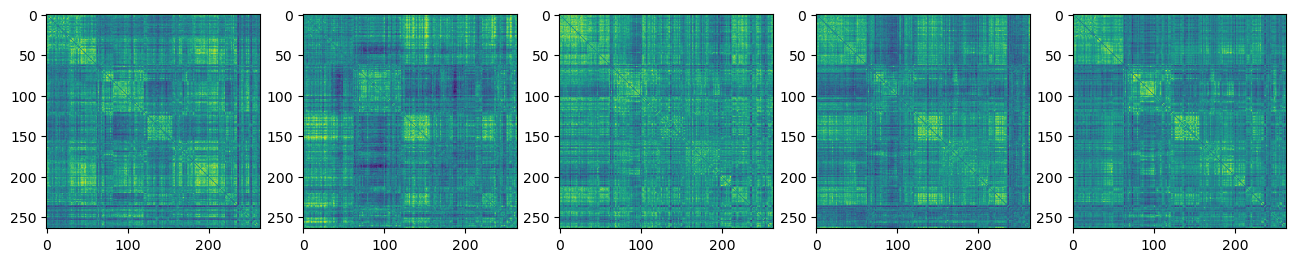

In [13]:
import matplotlib.pyplot as plt

n = 1000

with torch.no_grad():
    ag = 1*torch.ones(n).float().cuda()
    sx = 0*torch.ones(n).float().cuda()
    rc = 0*torch.ones(n).float().cuda()
    tidx = 0
    task = torch.ones(n).long().cuda()
    z = vae.gen(n)
    y = vae.dec(z, ag, sx, rc, task*(tidx == 0), task*(tidx == 1), task*(tidx == 2))
    y = y.detach().cpu().numpy()
    print(y.shape)

fig, ax = plt.subplots(1,5,figsize=(16,4))
ym = np.mean(y, axis=0)
ym2 = ym

ax[0].imshow(vec2mat(y[0]))
ax[1].imshow(vec2mat(y[1]))
ax[2].imshow(vec2mat(y[2]))
ax[3].imshow(vec2mat(y[3]))
ax[4].imshow(vec2mat(ym))

fig.show()

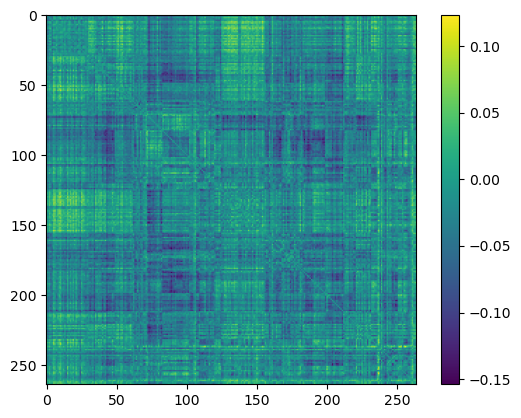

In [18]:
plt.imshow(vec2mat(ym2-ym1))
plt.colorbar()
plt.show()

In [19]:
# Save VAE

torch.save(vae.state_dict(), '/home/anton/Documents/Tulane/Research/ImageNomer/data/PNC/vae_1000_z30_cov6.torch')

print('Done')

Done
